# Load MOB data and preprocess

Preprocessing Script for data from J. Schumacher (H. Spors). 

In general there a two types of measurements: 1) IOS functional imaging, and 2) synapto-pHluorin functional imaging (containing "FRV" in datafolder name). Often a experiments.txt gives a short documentation of the measurements. 

Regarding the IOS data, the general procedure was to take GFP and green images between functional IOS measurements to trac MOR18-2 (GFP) and blood vessel (green) position throughout the measurements and control for animal movement. IOS recordings of individual stimuli are stored in .mat files. The mapping of .mat files and stimulus is noted in 'Measurement.xlxs'. Two setups (i.e. cameras) have been used for recording. The setup was changed in February 2010.

This script reads in this data and converts it to a TimeSeries object (as defined in FUimaging). It also applies some preprocessing to reduce the data to less than 2GB.

First we need to set the paths to the code and the data. Update this according to your environment.

In [1]:
import os
import sys
curdir = os.path.abspath(os.path.curdir)
sys.path.append(curdir)
sys.path.append(os.path.join(curdir,'FUImaging'))
data_path = os.path.abspath(os.path.join(os.path.pardir, "Soelter_et_al_raw_data"))

In [2]:
import csv, os, shutil
import numpy as np
from scipy.io import loadmat
from configobj import ConfigObj
from PIL import Image

from regnmf import ImageAnalysisComponents as ia #please have the FUimaging directory in your pythonpath
import dataimport

### Specify parameter

In [34]:
animal = '120326FRV'
#animal = '120125'
oldIOS = False
if oldIOS:
    datakey = 'conds' 
    rawpath = os.path.join(data_path, 'MOBraw', animal, 'raw') #if 'raw' is not working, look in datafolder for subfolder like raw1, rawpre, ...
else:
    datakey = 'Channel2' #Matlab variablename of the data (old IOS 'conds', IOS 100212:  (conds, 'binned'), sph: 'Channel2')
    rawpath = os.path.join(data_path, 'MOBraw', animal, '2p') #if 'raw' is not working, look in datafolder for subfolder like raw1, rawpre, ...
savepath = os.path.join(data_path, 'MOBconverted', animal)
config_file = os.path.join(data_path, 'configfiles', 'prepro', 'sph_meas.ini') #ios_meas.ini for IOS measurements, sph_meas.ini for synapto-pHluorin
datadictspath = os.path.join(data_path, 'DataDicts')

### Create preprocessing procedure with parameters from config file

In [35]:
cfg = ConfigObj(config_file, unrepr=True)
def preprocess(ts):
    if 'signal_cut' in cfg:
        ts = ia.CutOut(cfg['signal_cut'])(ts) #trim data to frame window defined in signal cut
    f0 =  ia.TrialMean()(ia.CutOut(cfg['baseline_cut'])(ts)) #calc resting activity
    if cfg['normalization'] == 'rel_change':
        ts = ia.RelativeChange()(ia.TrialMean(cfg['temporal_down'])(ts), f0) #calulate activity change divided by resting activity
    elif cfg['normalization'] == 'diff':
        ts = ia.Combine(np.subtract)(ia.TrialMean(cfg['temporal_down'])(ts), f0) #calulate activity change
    ts_temp = ts.copy()
    if cfg['lowfilt']:
        ts = ia.Filter(cfg['lowfilt'], cfg['lowfiltextend'], downscale=cfg['spatial_down'])(ts) #apply a lowpass filter
    if cfg['highfilt']:
        ts = ia.Combine(np.subtract)(ts, ia.Filter(cfg['highfilt'], cfg['highfiltextend'], downscale=cfg['spatial_down'])(ts_temp)) #apply a highpass filter
    if cfg['scale_factor']:
        ts._series *= cfg['scale_factor'] #scale data
    return ts

### Load dictionary which maps Odornames used by Jan Schumacher to CAS numbers of the Mombaerts Lab odor list

This file keeps track of odors used in any measurement.

In [36]:
name2cas = {l[1]:l[0] for l in csv.reader(open(os.path.join(datadictspath, 'Name2MomCas.tab')),  delimiter='\t')}

### Load Measurement.csv which contains the odor info for each measurment file

You have to manually create Measurement.csv from the Measurement.xlxs in the raw data folder (use tab as delimiter). Please label each column in the first row with

* __filename__ for relative path of measurement *.mat files
* __stimulus__ for blank (b) or odor (o) measurement
* __name__ for odor name
* __bulb__ for side of bulb
* [__concentration__] for dilution values 1:x
* [__extraInfo__] for all other information
 

#### Read in Measurement.csv

In [37]:
filedata = csv.reader(open(os.path.join(rawpath, 'Measurement.csv')), delimiter='\t')
properties = next(filedata)
metadata = [i for i in filedata]
print(properties)

['filename', 'stimulus', 'name', 'bulb', 'concentration', '', '', '', '', '', '', '']


### Check consistency of odor names 

Run following cell. If errors appear fix either spell errors in Measurement.csv or add the odor to the 'Name2MomCas.tab' file (assure that it is a unique new odor).

In [38]:
name_pos = properties.index('name')
filename_pos = properties.index('filename')
bulb_pos =  properties.index('bulb')
blank_pos = properties.index('stimulus')

errors = 0
for l_number, m in enumerate(metadata):
    odor = m[name_pos].strip()
    if odor not in name2cas:
        errors += 1
        print('!! line %d: no cas entry for %s !!'%(l_number+1, odor))
if errors > 0:
    print('====================================\n Errors, please correct')
else:
    print('Measurment.csv correct, please proceed')

Measurment.csv correct, please proceed


### Get data and preprocess according to config

get image shape metadata

In [39]:
try:
    param = loadmat(os.path.join(rawpath, 'Parameter.mat'))
except IOError:
    try:
        param = loadmat(os.path.join(rawpath, 'parameter.mat'))
    except IOError:
        filepath = metadata[0][filename_pos]
        filepath = os.path.join(rawpath, *filepath.split('\\')) 
        param = loadmat(filepath)
shape = (int(param['ys'][0, 0]), int(param['xs'][0, 0]))

create concatenated measurement file (load files and preprocess)

In [40]:
ts_all = None
for l_number, m in enumerate(metadata):
    filepath = m[filename_pos]
    #convert relative filepath (windows style) to absolute path (current os style)
    filepath = os.path.join(rawpath, *filepath.split('\\')) 
    
    matdata = loadmat(filepath)
    if isinstance(datakey, tuple):
        for dk in datakey:
            if dk in matdata:
                imagedata = matdata[dk].astype(float)
                continue
    else:
        imagedata = matdata[datakey].astype(float)
    stim_types = m[blank_pos].strip()
    # create stimulus label
    stimulus = name2cas[m[name_pos].strip()]
    stimulus_add = ''
    if 'concentration' in properties:
        stimulus_add += '_' + m[properties.index('concentration')]
    if 'extraInfo' in properties:
        stimulus_add += '_' + m[properties.index('extraInfo')]
    # check if only one measurment in file
    if len(stim_types)==1: #than add third axes for compatibility
        imagedata = imagedata[:,:,np.newaxis]
    
    # convert each file and concatenate
    for ix, blank_or_odor in enumerate(stim_types):
        # to save memory skip all blanks
        if cfg['skip_blank'] and blank_or_odor != 'o':
            continue
        full_stimulus = ('_'.join([stimulus, blank_or_odor])+stimulus_add).strip('_')
        ts = ia.TimeSeries(imagedata[:,:,ix].T, label_stimuli=[full_stimulus], shape=shape,
                           name='_'.join([animal,m[bulb_pos]])) 
        ts = preprocess(ts)
        ts_all = ia.SampleConcat()([ts_all, ts]) if (ts_all != None) else ts

if ('correct_bleach' in cfg) and cfg['correct_bleach']:
    # subtract mean blank timecourse
    mask = np.array(['b' in i for i in ts_all.label_stimuli])
    blank  = ts_all.trial_shaped()[mask]
    ts_all.set_series((ts_all.trial_shaped()-np.mean(blank,0)[np.newaxis]))    
        
if not os.path.exists(savepath): os.makedirs(savepath)
ts_all.save(os.path.join(savepath, os.path.splitext(os.path.basename(config_file))[0]))

### Create background image

look for manually converted bg.png images, if sucessfull proceed with next section. If bg image is tiff file, please convert manually. If it is matfile use one of the 2 options below

In [41]:
if os.path.exists(os.path.join(rawpath, 'bg.png')):
    shutil.copy2(os.path.join(rawpath, 'bg.png'), savepath)
    print('bg.png found, please proceed')
elif os.path.exists('/'+os.path.join(*(rawpath.split('/')[:-1]+['bg.png']))):
    shutil.copy2('/'+os.path.join(*(rawpath.split('/')[:-1]+['bg.png'])), savepath)
    print('bg.png found, please proceed')
else:
    print('!!! no bg available, please create !!!')

!!! no bg available, please create !!!


#### (1) create bg from mat file (for old IOS measurements)

In [ ]:
bgfile =  'GFP9.A'
im_mat = loadmat(os.path.join(rawpath, bgfile))
im_data = im_mat[datakey]
shape = (int(im_mat['ys']), int(im_mat['xs']))

im = Image.fromarray(np.mean(im_data,1).reshape(shape))
im = im.convert('L')
im.save(os.path.join(savepath, 'bg.png'))

#### (2) create bg from restingfluo.mat file (for FRV measurements)

In [ ]:
im_data = loadmat(os.path.join(rawpath, 'restingfluo.mat'))

In [ ]:
im_data = loadmat(os.path.join(rawpath, 'restingfluo.mat'))['restingfluo']
im_data /= np.max(im_data)
im = Image.fromarray(im_data*256)
im = im.convert('L')
im.save(os.path.join(savepath, 'bg.png'))

### Convert available handdrawn rois to python

In [42]:
roipath = rawpath #'/'+os.path.join(*(rawpath.split('/')[:-1]))
if oldIOS:
    shape_keys = ('nxis', 'nyis')
    roifile = 'nrois.mat'
else:
    shape_keys = ('xis', 'yis')
    roifile = 'rois.mat'
baseshape = 128 #1024 for *sph measurements, 128 for *FRV measurements
roiload = dataimport.LoadRoi(roipath, roifile, shape_keys, baseshape)
rois = roiload(ts_all.shape)
rois.save(os.path.join(savepath, 'rois'))

#### show ROI outlines just to check

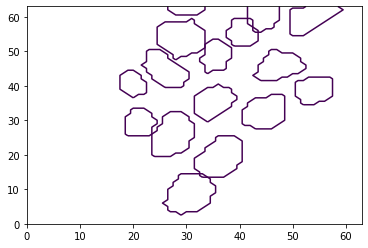

In [43]:
import pylab as plt
for roi in rois.shaped2D():
    plt.contour(roi,[0.5])
plt.show()

